In [1]:
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort
from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.xgboost import *
from Functions.Models.evaluation import *
from Functions.NLP.alertp1_nlp import *
from Functions.NLP.data_with_nlp import *
from Functions.pipeline import *

# Functions

In [2]:
def get_top_words(lda, vectorizer, n_top_words=10):
    # Extract top words for each topic
    top_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words.append([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

    # Print top words for each topic
    for i, words in enumerate(top_words):
        print(f'Topic {i}: ' + ', '.join(words))

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def lda_topics(df, column, n_components=5):
    # Convert text data into a bag of words representation
    vectorizer = CountVectorizer(analyzer='word',min_df=10)
    data_vectorized = vectorizer.fit_transform(df[column])

    # Fit LDA model to the data
    lda = LatentDirichletAllocation(n_components=n_components)
    lda.fit(data_vectorized)

    # Transform data to get topic distribution for each row
    topic_dist = lda.transform(data_vectorized)

    # Create new dataframe with topic columns
    topic_columns = [f'topic_{i}' for i in range(n_components)]
    topic_df = pd.DataFrame(topic_dist, columns=topic_columns)

    # Concatenate topic dataframe with original dataframe
    df = pd.concat([df.reset_index(drop=True), topic_df], axis=1)
                   
    get_top_words(lda, vectorizer)

    return df

# Load and Prepare Data

In [4]:
alertP1=connection("credentials.txt")


Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
10


/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/connection/connection.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from numpy import argsort
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.evaluation import *
from Functions.NLP.alertp1_nlp import *
from Functions.NLP.data_with_nlp import *

def pre_process(df):
    #Additional Functions

    def sort_values(df):
        df = df.sort_values('DATA_RECEPCAO')
        return df

    def text_only(df):
        df=df[df['text_length']>0]
        return df

    def medication_count(df):
        df['medication_count']=df['medication_level_1']+df['medication_level_2']+df['medication_level_3']
        return df
    def medication_concentration(df):
        df['medication_concentration']=df['medication_count']/df['text_length']
        return df
    def medication1_concentration(df):
        df['medication1_concentration']=df['medication_level_1']/df['text_length']
        return df
    
    def medication2_concentration(df):
        df['medication2_concentration']=df['medication_level_2']/df['text_length']
        return df
    
    def medication3_concentration(df):
        df['medication3_concentration']=df['medication_level_3']/df['text_length']
        return df
    
    
    def symptoms_count(df):
        df['symptoms_count']=df['symptom_0']+df['symptom_1']
        return df

    def symptoms_concentration(df):
        df['symptoms_concentration']=df['symptoms_count']/df['text_length']
        return df
    def symptoms1_concentration(df):
        df['symptoms1_concentration']=df['symptom_1']/df['text_length']
        return df
    def symptoms0_concentration(df):
        df['symptoms0_concentration']=df['symptom_0']/df['text_length']
        return df

    def exams_concentration(df):
        df['exams_concentration']=df['exam_identified']/df['text_length']
        return df
    def comorbidities_concentration(df):
        df['comorbidities_concentration']=df['comorbidity_identified']/df['text_length']
        return df

    #Pipeline

    pipeline = Pipeline([
        #Data Cleaning
        ('Date Format', FunctionTransformer(date_format_alertP1)),
        ('Replace Blanks', FunctionTransformer(replace_blank)),
        ('Duplicated Entities', FunctionTransformer(entity_duplicated)),
        ('Lower Case Text ', FunctionTransformer(lowering_text)),
        ('Target Variable', FunctionTransformer(result)),
        #Structured Features
        ('Accepted Before', FunctionTransformer(bef_accepted)),
        ('Area Classification', FunctionTransformer(class_area)),
        ('Text Length', FunctionTransformer(text_length)),
        ('Referral Steps', FunctionTransformer(referral_steps)),
        ('Speciality', FunctionTransformer(speciality)),
        ('Unit', FunctionTransformer(unit)),
        #NLP Features
        ('symptoms_column', FunctionTransformer(symptoms_column)),
        ('exams', FunctionTransformer(exams)),
        ('comorbidities', FunctionTransformer(comorbidities)),
        ('medication_column', FunctionTransformer(medication_column)),
        ('Medication Total Count', FunctionTransformer(medication_count)),
        ('Medication Concentration', FunctionTransformer(medication_concentration)),
        ('Medication1 Concentration', FunctionTransformer(medication1_concentration)),
        ('Medication2 Concentration', FunctionTransformer(medication2_concentration)),
        ('Medication3 Concentration', FunctionTransformer(medication3_concentration)),
        ('Symptoms Total Count', FunctionTransformer(symptoms_count)),
        ('Symptoms Concentration', FunctionTransformer(symptoms_concentration)),
        ('Symptoms0 Concentration', FunctionTransformer(symptoms0_concentration)),
        ('Symptoms1 Concentration', FunctionTransformer(symptoms1_concentration)),
        ('exams Concentration', FunctionTransformer(exams_concentration)),
        ('comorbidities Concentration', FunctionTransformer(comorbidities_concentration)),
        ('synonyms', FunctionTransformer(synonyms)),
        ('Retrieve original text', FunctionTransformer(lowering_text)),
        ('clean_text', FunctionTransformer(clean_text)),
        #Dummies
        ('Dummies', FunctionTransformer(structured_data_dummies)),
        #Keep only text rows
        ('Text Only', FunctionTransformer(text_only)),
        #Sort Values
        ('Sort Values', FunctionTransformer(sort_values))
    ])

    transformed_data = pipeline.fit_transform(df)

    return transformed_data

In [9]:
data = pre_process(alertP1)

/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [ ]:
data['clean_text'] = data['clean_text'].str.replace(r'\d+', '', regex=True)

names = ['costa', 'silva', 'santos', 'ferreira', 'pereira', 'oliveira', 'rodrigues', 'maria', 'carolina', 'luisa', 'raquel', 'paula', 'joana', 'rita', 'manuel', 'joao', 'jose', 'francisco', 'antonio', 'luis', 'pedro']
months = ["jan","fev","mar","abr","mai","jun","jul","ago","set","out","nov","dez"]
for name in names:
    data['clean_text'] = data['clean_text'].str.replace(name, '')
for month in months:
    data['clean_text'] = data['clean_text'].str.replace(name, '')

NameError: name 'data' is not defined

In [ ]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16,shuffle=False)


# LDA Model

## Matrix and Sparsicity

The sparsicity of a document-term matrix is the percentage of cells in the matrix that contain non-zero values. A higher sparsicity indicates that the matrix is more sparse, meaning that there are more cells with zero values. In the context of topic modeling using LDA, a sparse matrix indicates that most of the words in the corpus are not related to each other and do not appear together frequently in the documents.

In the context of building a topic modeling model using LDA, it is generally better to have a document-term matrix with a high sparsity (a high percentage of zero values) rather than a dense matrix with a low sparsity (a low percentage of zero values). This is because a sparse matrix contains more information about the distribution of words across the documents, and is more likely to reveal the underlying topics in the corpus.

In [ ]:
vectorizer = CountVectorizer(analyzer='word',min_df=10)
data_vectorized = vectorizer.fit_transform(X_train["clean_text"])

In [ ]:
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.580184100775442 %


Matrix is very sparse!

## Build the model

In [43]:
lda_model = LatentDirichletAllocation(n_components=20)
lda_output = lda_model.fit_transform(data_vectorized)

## Perplexity and Log-likelihood (Evaluation)

In [44]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -241832.1043014585
Perplexity:  702.9701435845186
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


## GridSearch

In [45]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [5, 10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 10, 15, 20, 25, 30]})

In [46]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -52686.16600779089
Model Perplexity:  601.8409319665784


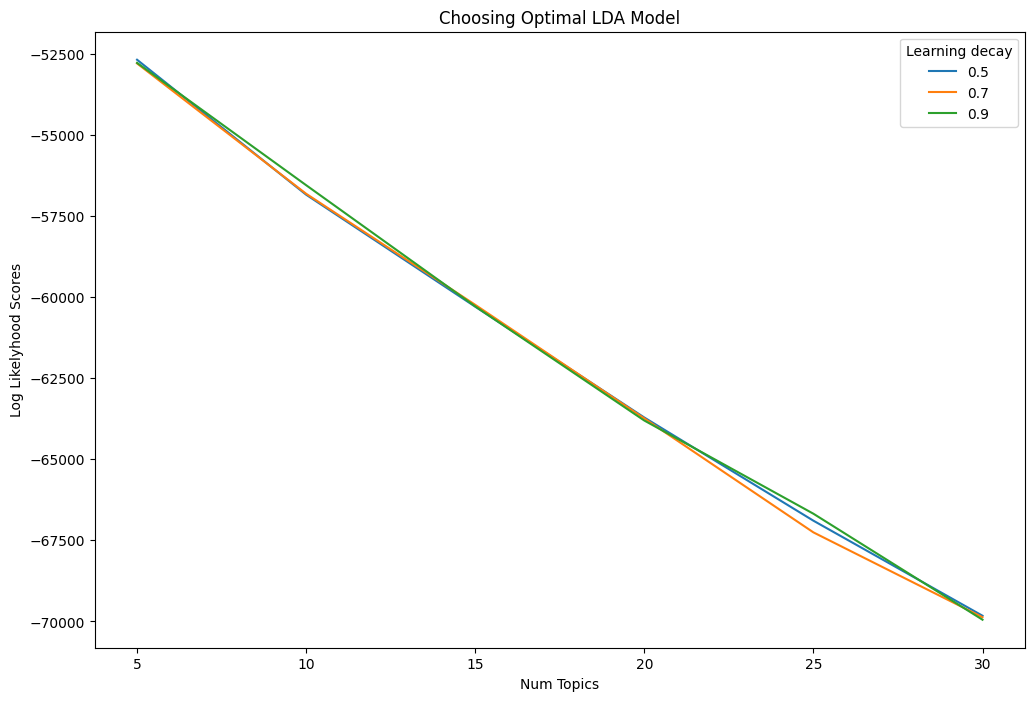

In [47]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(mean_score) for mean_score, params in zip(model.cv_results_['mean_test_score'], model.cv_results_['params']) if params['learning_decay']==0.5]
log_likelyhoods_7 = [round(mean_score) for mean_score, params in zip(model.cv_results_['mean_test_score'], model.cv_results_['params']) if params['learning_decay']==0.7]
log_likelyhoods_9 = [round(mean_score) for mean_score, params in zip(model.cv_results_['mean_test_score'], model.cv_results_['params']) if params['learning_decay']==0.9]


# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

### Redo a GridSearch for lower number of topics

In [26]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [1,2,3,4,5], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model_small = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model_small.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [1, 2, 3, 4, 5]})

In [27]:
# Best Model
best_lda_model_small = model_small.best_estimator_

# Model Parameters
print("Best Model's Params: ", model_small.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model_small.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model_small.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 1}
Best Log Likelihood Score:  -53303.4165514783
Model Perplexity:  664.8398964649293


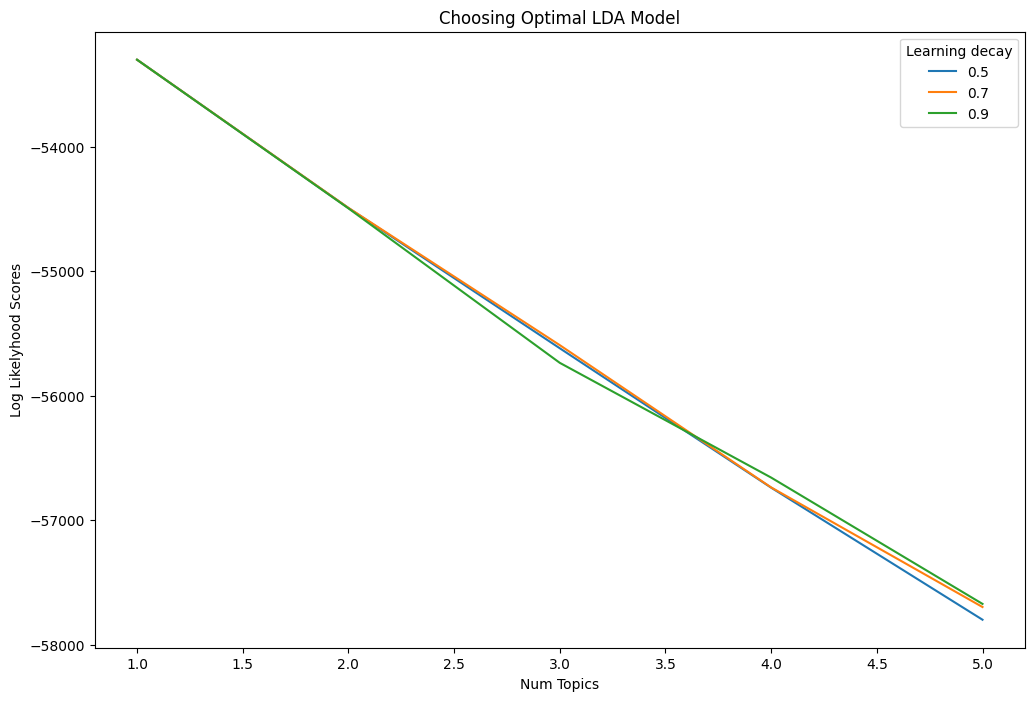

In [29]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [1,2,3,4,5]
log_likelyhoods_5 = [round(mean_score) for mean_score, params in zip(model_small.cv_results_['mean_test_score'], model_small.cv_results_['params']) if params['learning_decay']==0.5]
log_likelyhoods_7 = [round(mean_score) for mean_score, params in zip(model_small.cv_results_['mean_test_score'], model_small.cv_results_['params']) if params['learning_decay']==0.7]
log_likelyhoods_9 = [round(mean_score) for mean_score, params in zip(model_small.cv_results_['mean_test_score'], model_small.cv_results_['params']) if params['learning_decay']==0.9]


# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## 5-Topics Model

Even if it's not the one with the best results, it's seems more reasonable to have multiple topics on this analyis instead of only one. At least for a first analysis.

In [48]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(X_train))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.010000,0.960000,0.010000,0.010000,0.010000,1
Doc1,0.070000,0.070000,0.730000,0.070000,0.070000,2
Doc2,0.850000,0.010000,0.130000,0.010000,0.010000,0
Doc3,0.010000,0.940000,0.010000,0.010000,0.010000,1
Doc4,0.030000,0.030000,0.030000,0.480000,0.430000,3
Doc5,0.400000,0.000000,0.100000,0.000000,0.490000,4
Doc6,0.070000,0.070000,0.730000,0.070000,0.070000,2
Doc7,0.200000,0.200000,0.200000,0.200000,0.200000,0
Doc8,0.000000,0.000000,0.990000,0.000000,0.000000,2
Doc9,0.000000,0.000000,0.280000,0.250000,0.460000,4


In [49]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,398
1,0,345
2,2,225
3,4,195
4,3,124


In [50]:
# get the topic-term distribution from the fitted LDA model
topic_term_dists = best_lda_model.components_ / best_lda_model.components_.sum(axis=1)[:, np.newaxis]

# get the document-topic distribution by transforming the document-term matrix using the fitted LDA model
doc_topic_dists = best_lda_model.transform(data_vectorized)

# get the document lengths (number of words per document) by summing the document-term matrix along the columns axis
doc_lengths = data_vectorized.sum(axis=1).getA1()

# get the vocabulary from the vectorizer object
vocab = vectorizer.get_feature_names_out()

# get the term frequencies by summing the document-term matrix along the rows axis
term_frequency = data_vectorized.sum(axis=0).getA1()

In [51]:
import pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency)
panel


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.051685  0.092637       1        1  32.885107
1     -0.026680  0.148916       2        1  24.999649
4     -0.097871 -0.104233       3        1  21.210624
2      0.292418 -0.042571       4        1  11.720873
3     -0.116183 -0.094749       5        1   9.183748, topic_info=            Term        Freq       Total Category  logprob  loglift
383     familiar  270.000000  270.000000  Default  30.0000  30.0000
410        geral  198.000000  198.000000  Default  29.0000  29.0000
546     medicina  201.000000  201.000000  Default  28.0000  28.0000
161      clinico  179.000000  179.000000  Default  27.0000  27.0000
762    relatorio  136.000000  136.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
443          hta   23.688790  209.913346   Topic5  -4.9630   0.2060
282       doente   25.857266  502.430868   Topic5  -4.8754  -0.5791
543      medicar   21.228029  272.356736   Topic5  -5.0727  -0.1641
165    cognitivo   20.278946  122.302084   Topic5  -5.1184   0.5908
32   agravamento   20.517749  166.838187   Topic5  -5.1067   0.2920

[337 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1         3  0.058180         abr
1         4  0.872697         abr
2         1  0.967171       abril
7         3  0.952990  acentuaçao
18        1  0.068069      actual
...     ...       ...         ...
937       2  0.959526      vomito
944       1  0.956853       ácido
946       1  0.724098      último
946       2  0.176609      último
946       4  0.088305      último

[732 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])

We can see that Topic 5 is part of Topic 3 and that Topic 1 and 2 are similar. Therefore let's reduce the number of topics to 3 to avoid duplicates.

## 3-Topics Model

In [53]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [3], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [3]})

In [61]:
# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score:  -50878.95498454963
Model Perplexity:  599.633996092262


In [58]:
# Best Model
best_lda_model = model.best_estimator_

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(X_train))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.020000,0.970000,0.020000,1
Doc1,0.110000,0.110000,0.780000,2
Doc2,0.010000,0.860000,0.120000,1
Doc3,0.040000,0.930000,0.030000,1
Doc4,0.580000,0.360000,0.050000,0
Doc5,0.990000,0.000000,0.000000,0
Doc6,0.110000,0.110000,0.780000,2
Doc7,0.330000,0.330000,0.330000,0
Doc8,0.990000,0.010000,0.010000,0
Doc9,0.900000,0.090000,0.010000,0


In [59]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,734
1,2,282
2,0,271


In [60]:
# get the topic-term distribution from the fitted LDA model
topic_term_dists = best_lda_model.components_ / best_lda_model.components_.sum(axis=1)[:, np.newaxis]

# get the document-topic distribution by transforming the document-term matrix using the fitted LDA model
doc_topic_dists = best_lda_model.transform(data_vectorized)

# get the document lengths (number of words per document) by summing the document-term matrix along the columns axis
doc_lengths = data_vectorized.sum(axis=1).getA1()

# get the vocabulary from the vectorizer object
vocab = vectorizer.get_feature_names_out()

# get the term frequencies by summing the document-term matrix along the rows axis
term_frequency = data_vectorized.sum(axis=0).getA1()

import pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency)
panel


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.143326  0.064730       1        1  54.160784
0     -0.001039 -0.130888       2        1  31.949161
2     -0.142288  0.066158       3        1  13.890055, topic_info=          Term        Freq       Total Category  logprob  loglift
161    clinico  181.000000  181.000000  Default  30.0000  30.0000
762  relatorio  137.000000  137.000000  Default  29.0000  29.0000
410      geral  202.000000  202.000000  Default  28.0000  28.0000
383   familiar  274.000000  274.000000  Default  27.0000  27.0000
546   medicina  205.000000  205.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
282     doente   35.399113  503.215717   Topic3  -4.9750  -0.6803
105    atrofia   22.907248   59.110533   Topic3  -5.4103   1.0260
533    marchar   23.394230   70.054367   Topic3  -5.3892   0.8772
792         se   27.589316  307.592021   Topic3  -5.2243  -0.4373
645      outro   24.983561  154.919936   Topic3  -5.3235   0.1493

[215 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
8         2  0.916576  acentuação
8         3  0.055550  acentuação
10        1  0.307448       acido
10        2  0.027950       acido
10        3  0.670796       acido
...     ...       ...         ...
928       3  0.952563         vih
933       3  0.952661    vitamina
935       1  0.985091      voltar
938       1  0.964905       vosso
941       1  0.991408      vários

[371 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

# Create New Features

In [68]:
def train_and_predict_lda(X, n_components=3, learning_decay=0.5, random_state=0):
    # split the data into training and test sets
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=16, shuffle=False)
    
    # create a CountVectorizer to vectorize the text data
    vectorizer = CountVectorizer()
    
    # vectorize the text data in the clean_text column of X_train
    X_train_vectorized = vectorizer.fit_transform(X_train['clean_text'])
    
    # create and fit the LDA model
    lda = LatentDirichletAllocation(n_components=n_components, learning_decay=learning_decay, random_state=random_state)
    lda.fit(X_train_vectorized)
    
    # predict the topic probabilities for the training data
    train_topic_probs = lda.transform(X_train_vectorized)
    
    # add the topic probabilities as columns to the X DataFrame for the training rows
    for i in range(n_components):
        X.loc[X_train.index, f'topic_{i}'] = train_topic_probs[:, i]
    
    # vectorize the text data in the clean_text column of X_test
    X_test_vectorized = vectorizer.transform(X_test['clean_text'])
    
    # predict the topic probabilities for the test data
    test_topic_probs = lda.transform(X_test_vectorized)
    
    # add the topic probabilities as columns to the X DataFrame for the test rows
    for i in range(n_components):
        X.loc[X_test.index, f'topic_{i}'] = test_topic_probs[:, i]

In [73]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida',"Texto"]
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable

train_and_predict_lda(X, n_components=3, learning_decay=0.5, random_state=0)

X = X.drop(["clean_text"],axis=1)

In [74]:
y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [75]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.81,0.95,0.81,0.89
1,Precision-Recall trade-off,0.47,0.81,0.98,0.79,0.88
2,Balanced Accuracy,0.65,0.78,0.80,0.87,0.90
3,Cohen's Kappa,0.61,0.80,0.85,0.86,0.90
4,Limit to K,0.64,0.78,0.82,0.86,0.89


In [76]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.70,0.96,0.70,0.69
1,Precision-Recall trade-off,0.47,0.67,0.98,0.67,0.66
2,Balanced Accuracy,0.65,0.73,0.82,0.78,0.77
3,Cohen's Kappa,0.61,0.71,0.86,0.74,0.75
4,Limit to K,0.64,0.72,0.82,0.77,0.76


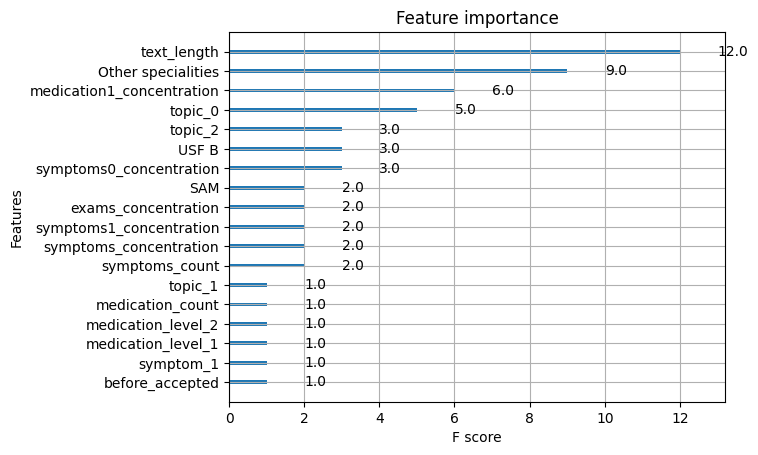

In [77]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()